In [64]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from model.pspunet import pspunet
from data_loader.display import create_mask


gpus = tf.config.experimental.list_physical_devices('GPU')

IMG_WIDTH = 480
IMG_HEIGHT = 272
n_classes = 7

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)
        
model = pspunet((IMG_HEIGHT, IMG_WIDTH ,3), n_classes)
model.load_weights("pspunet_weight.h5")


In [236]:
def distance(value):
    dist = math.sqrt(value[0]*value[0] + value[1]*value[1] + value[2]*value[2])
    return (dist, dist, dist)

def point2dist(arr):    #0.25초정도 소요 
    arr = np.reshape(arr, (270*480,3))
    dist = list(map(lambda value : distance(value) , arr))  #여기 더 빠른 로직있으면 변경해주세용
    dist= np.array(dist)
    dist = np.reshape(dist, (270,480,3))
    #dist[(dist<0.1)] = 0 
    dist[(dist>50)] = 50
    return dist

def seg_predict(img):
    frame = cv2.resize(img,(480,272))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame/=255
    pre = model.predict(frame[tf.newaxis, ...])
    pre = create_mask(pre).numpy()
    frame2 = frame/2
    #frame2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2BGR)
    frame2[(pre==1).all(axis=2)] += [0, 0, 0] #""bike_lane_normal", "sidewalk_asphalt", "sidewalk_urethane""
    frame2[(pre==2).all(axis=2)] += [0.5, 0.5,0] # "caution_zone_stairs", "caution_zone_manhole", "caution_zone_tree_zone", "caution_zone_grating", "caution_zone_repair_zone"]
    frame2[(pre==3).all(axis=2)] += [0.2, 0.7, 0.5] #"alley_crosswalk","roadway_crosswalk"
    frame2[(pre==4).all(axis=2)] += [0, 0.5, 0.5] #"braille_guide_blocks_normal", "braille_guide_blocks_damaged"
    frame2[(pre==5).all(axis=2)] += [0, 0, 0.5] #"roadway_normal","alley_normal","alley_speed_bump", "alley_damaged""
    frame2[(pre==6).all(axis=2)] += [0.5, 0, 0] #"sidewalk_blocks","sidewalk_cement" , "sidewalk_soil_stone", "sidewalk_damaged","sidewalk_other"
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    frame[(pre!=6).all(axis=2)]=0
    
    frame = cv2.resize(frame,(480,270))
    frame2 = cv2.resize(frame2,(480,270))

    return frame2, frame

In [66]:
data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

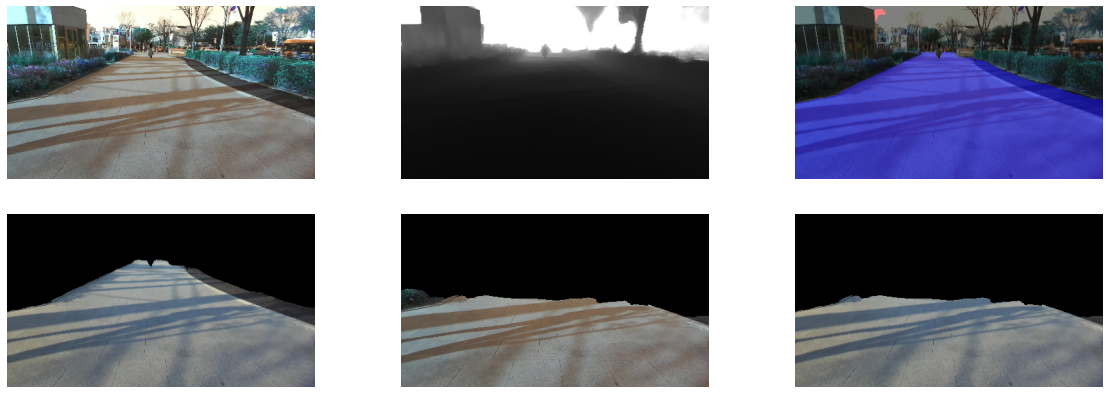

In [117]:
max_dist = 5
idx = 800

img_copy = img[idx].copy()
seg_img, side = seg_predict(img_copy)

plt.figure(figsize=(20,7))
plt.subplot(2,3,1)
plt.axis("off")
plt.imshow(img[idx]/255)

plt.subplot(2,3,2)
plt.axis("off")
plt.imshow(point2dist(point_cloud[idx])/50)

plt.subplot(2,3,3)
plt.axis("off")
plt.imshow(seg_img)

plt.subplot(2,3,4)
plt.axis("off")
plt.imshow(side)

plt.subplot(2,3,5)
plt.axis("off")
img_copy[(point2dist(point_cloud[idx])>max_dist)]= 0
plt.imshow(img_copy/255)

plt.subplot(2,3,6)
plt.axis("off")
side[(img_copy==0)] = 0
plt.imshow(side)




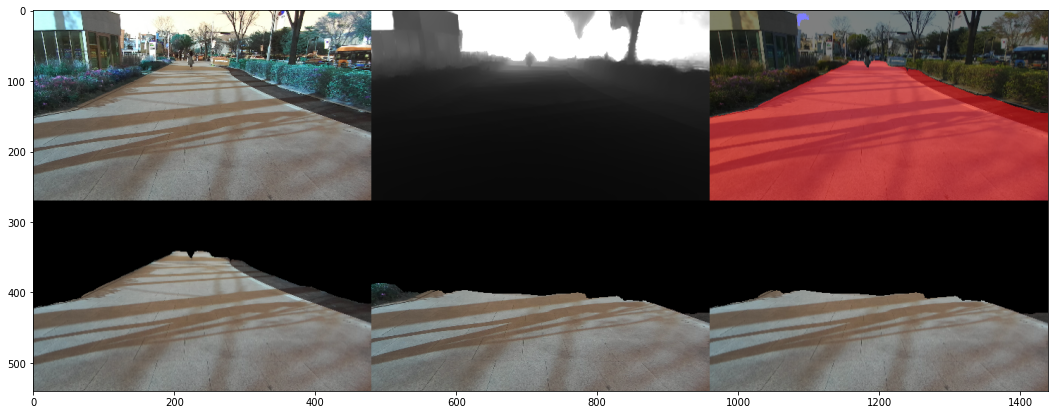

In [237]:
max_dist = 5
idx = 800

img_copy = img[idx].copy()
seg_img, side = seg_predict(img_copy)

img_ori = img[idx]/255
depth = point2dist(point_cloud[idx])/50
depth = np.float32(depth)
side2= side.copy()
img_copy[(point2dist(point_cloud[idx])>max_dist)]= 0
side2[(img_copy==0)] = 0

h = cv2.hconcat([img[idx]/255 , depth ,seg_img])
img_copy[(point2dist(point_cloud[idx])>max_dist)]= 0
h2 = cv2.hconcat([side , img_copy/255 ,side2])
v = cv2.vconcat([h ,h2])

plt.figure(figsize=(20,7))
plt.imshow(v)



In [ ]:
max_dist = 5
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('selly_vision.mp4', fourcc, 30.0, (1440, 540))

for idx in range(1100):
    start_time =time.time()
    img_copy = img[idx].copy()
    seg_img, side = seg_predict(img_copy)

    img_ori = img[idx]/255
    depth = point2dist(point_cloud[idx])/50
    depth = np.float32(depth)
    side2= side.copy()
    img_copy[(point2dist(point_cloud[idx])>max_dist)]= 0
    side2[(img_copy==0)] = 0

    h = cv2.hconcat([img[idx]/255 , depth ,seg_img])
    img_copy[(point2dist(point_cloud[idx])>max_dist)]= 0
    h2 = cv2.hconcat([side , img_copy/255 ,side2])
    v = cv2.vconcat([h ,h2])
    video = np.uint8(v*255)
    out.write(video)
    print(time.time()-start_time)
    
out.release()



0.8425066471099854
0.8394632339477539
0.8461744785308838
0.8308618068695068
0.8336303234100342
0.8405940532684326
0.8430047035217285
0.8363361358642578
0.8337569236755371
0.8348984718322754
0.832362174987793
0.8198623657226562
0.8245832920074463
0.8405342102050781
0.8525559902191162
0.8365817070007324
0.8295168876647949
0.8455615043640137
0.8351101875305176
0.8555166721343994
0.8526444435119629
0.8475406169891357
0.8447725772857666
0.8361232280731201
0.836674690246582
0.8429696559906006
0.8395216464996338
0.8566889762878418
0.8382484912872314
0.8397996425628662
0.8427116870880127
0.8383688926696777
0.833362340927124
0.8405838012695312
0.849102258682251
0.836794376373291
0.8390834331512451
0.8521397113800049
0.8507885932922363
0.8496925830841064
0.8533320426940918
0.8335630893707275
0.8522872924804688
0.8381915092468262
0.8434700965881348
0.8520455360412598
0.8394145965576172
0.8301494121551514
0.8438432216644287
0.8440570831298828
0.8445034027099609
0.8426446914672852
0.837034463882446

In [239]:
out.release()
